## Helper functions

### Visualization helpers

In [3]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import time
import imageio
%matplotlib inline


def init_fig(env):
    plt.figure()
    plt.title(env.spec.id)
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, step, reward, done, stl_rob, stl_violated):
    title = plt.title(
        f"{env.spec.id}\n" +
        f"Step: {step} | Reward: {reward} | Done: {done}\n" +
        f"STL: {stl_rob[0]:.3f} | Violated: {stl_violated}"
    )
    if done or stl_violated:
        plt.setp(title, color='r')
    else:
        plt.setp(title, color='k')
    img.set_data(env.render(mode='rgb_array'))
    fig = plt.gcf()
    display.display(fig)
    display.clear_output(wait=True)
    
    return np.asarray(fig.canvas.buffer_rgba())

def visual_episode(env, next_action, compute_stl_rob, is_stl_violated,
                   max_episode_steps=100, reset_to=None, visualize_in_notebook=True,
                   sleep=0.01, save_gif=None, model_reset=None):
    if reset_to is not None:
        obs = env.reset_to(reset_to)
    else:
        obs = env.reset()
    
    if model_reset is not None:
        model_reset()
    
    if save_gif is not None:
        gif = []
    else:
        gif = None

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    space = env.observation_space
    total_reward = 0.0
    obs_records = [obs]
    
    for step in range(1, max_episode_steps+1):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        obs_records.append(np.clip(obs, space.low, space.high))

        if visualize_in_notebook:
            rob = compute_stl_rob(np.asarray(obs_records))
            fig_data = update_fig(img, env, step, total_reward, done, rob, is_stl_violated(rob))
            if save_gif is not None:
                gif.append(fig_data)
        else:
            env.render()

        if sleep > 0.0:
            time.sleep(sleep)
    
    if save_gif is not None:
        imageio.mimsave(save_gif, [data for data in gif], fps=10)

In [4]:
def visual_deviated_env(x, reset_to, save_gif=None):
    env = build_env(x)
    env.seed(seed)
    visual_episode(env, next_action, compute_stl_rob, is_stl_violated, max_episode_steps=max_episode_steps,
                   reset_to=reset_to, save_gif=save_gif, model_reset=model_reset)
    env.close()

### Functions for scaling the variable

In [5]:
def scale(x, bounds):
    """Scale the input numbers in [0, 1] to the range of each variable"""
    return bounds[:, 0] + x * (bounds[:, 1] - bounds[:, 0])

def normalize(x_scaled, bounds):
    return (x_scaled - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

### STL robustness computation helpers

In [6]:
import signal_tl as stl

def compute_stl_rob(records):
    if records.ndim == 2:
        records = np.array([records])
    
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = build_stl_trace(records[i], time_index)
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    
    return np.array(robs)

### STL falsification helpers

#### Falsification by random sampling

In [7]:
def random_sample(env):
    space = env.observation_space
    episode_obs_records = []

    for episode in range(max_episodes):
        obs = env.reset()
        
        if model_reset is not None:
            model_reset()
        
        obs_records = [obs]
        
        for step in range(max_episode_steps):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            obs_records.append(np.clip(obs, space.low, space.high))

        episode_obs_records.append(obs_records)

    return np.array(episode_obs_records)

def falsification_by_random_sample(x):
    """
    x is the deviation parameter in its original domain
    """
    env = build_env(x)
    env.seed(seed)
    records = random_sample(env)
    env.close()
    return compute_stl_rob(records).min()

def scaled_falsification_by_random_sample(x):
    """
    Wrapped falsification function where input x is in [0, 1] and should be scaled to the original domain.
    """
    return falsification_by_random_sample(scale(x, dev_bounds))

#### Falsification by CMA

In [8]:
import cma

def episode_by_init(env, x):
    space = env.observation_space
    obs = env.reset_to(x)
    obs_records = [obs]
    
    if model_reset is not None:
        model_reset()
    
    for step in range(max_episode_steps):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        obs_records.append(np.clip(obs, space.low, space.high))
    
    return np.array(obs_records)

def falsification_by_CMA(x):
    env = build_env(x)
    env.seed(seed)
    
    def objective(y):
        record = episode_by_init(env, y)
        return compute_stl_rob(record)[0]
    
    y0 = np.zeros(len(falsify_range)) # TODO: https://lig-kobe-grenoble.imag.fr/wp-content/uploads/2018/03/05.-Session-4-presentation-1-Thao-Dang.pdf
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale(y, falsify_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': stl_falsify_target,
         'verbose': -9, 'seed': seed}
    )
    
    env.close()
    return es.result.fbest, scale(min_x, falsify_range)

def scaled_falsification_by_CMA(x):
    fbest, _ = falsification_by_CMA(scale(x, dev_bounds))
    return fbest

#### Compare two sampling methods

In [9]:
def compare_falsification(trials):
    for x in np.random.rand(trials, len(dev_bounds)):
        est1 = scaled_falsification_by_random_sample(x)
        est2 = scaled_falsification_by_CMA(x)
        if est1 < est2:
            print(est1, est2, "Random Sample")
        else:
            print(est1, est2, "CMA")

### Miscs

In [10]:
def evaluate_dev(x, gif):
    robustness, x_init = falsification_by_CMA(x)
    visual_deviated_env(x, x_init, gif)
    print("Deviation:", x)
    print("Deviation distance:", deviation_dist(x))
    print("Initial parameter:", x_init)
    print("Min robustness value:", robustness)

### Robustness computation helpers

In [11]:
import os

if not os.path.exists('gifs'):
    os.mkdir('gifs')

In [12]:
# l-2 norm distance, the input x is in the original domain
def deviation_dist(x):
    """The variables of the objective function are normalized to [0, 1)"""
    return np.sqrt(np.sum((x - x_original) ** 2))

# wrapped objective function where input x is in [0, 1] and should be scaled to the original domain
def scaled_deviation_dist(x):
    return deviation_dist(scale(x, dev_bounds))

In [13]:
def dev_violates_stl():
    x0 = normalize(x_original, dev_bounds)
    sigma0 = 0.4

    _, es = cma.fmin2(
        scaled_falsification_by_CMA,
        x0,
        sigma0,
        {'bounds': [0.0, 1.0], 'ftarget': stl_falsify_target, 'tolstagnation': 0,
         'tolx': 1e-5, 'timeout': timeout * 60},
    )
    print(es.result)
    return scale(es.result.xbest, dev_bounds)

In [14]:
def min_dev_violates_stl():
    min_dev = np.inf
    min_x = None
    for i in range(num_tries):
        print(f'\n================ Trial {i} ==============>')

        x0 = normalize(x_original, dev_bounds)
        sigma0 = 0.2

        cfun = cma.ConstrainedFitnessAL(
            scaled_deviation_dist,
            lambda x: [scaled_falsification_by_CMA(x)],
            find_feasible_first=True
        )
        _, es = cma.fmin2(
            cfun,
            x0,
            sigma0,
            {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5,
             'timeout': timeout / num_tries * 60},
            callback=cfun.update
        )

        print(es.result)
        if cfun.best_feas.info is None:
            cfun.find_feasible(es)
        print(cfun.best_feas.info)

        x = cfun.best_feas.info['x']
        dev = deviation_dist(scale(x, dev_bounds))
        if dev < min_dev:
            min_dev = dev
            min_x = x
    
    return scale(min_x, dev_bounds)

In [15]:
def max_safe_dev():
    max_dev = -np.inf
    max_x = None
    for i in range(num_tries):
        print(f'\n================ Trial {i} ==============>')

        x0 = normalize(x_original, dev_bounds)
        sigma0 = 0.2

        cfun = cma.ConstrainedFitnessAL(
            lambda x: -scaled_deviation_dist(x), # maximize distance
            lambda x: [-scaled_falsification_by_CMA(x)], # robustness >= 0
        #     find_feasible_first=True # assume the initial is already feasible
        )
        _, es = cma.fmin2(
            cfun,
            x0,
            sigma0,
            {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolx': 1e-5, 'timeout': timeout / num_tries * 60},
            callback=cfun.update
        )

        print(es.result)
        if cfun.best_feas.info is None:
            cfun.find_feasible(es)
        print(cfun.best_feas.info)

        x = cfun.best_feas.info['x']
        dev = deviation_dist(scale(x, dev_bounds))
        if dev > max_dev:
            max_dev = dev
            max_x = x
    
    return scale(max_x, dev_bounds)

## Config your environment and agent

### TODO: Define the environment

In [16]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state):
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

In [17]:
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([masscart, force_mag])

# define the range of the variables to falsify
falsify_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

# define the deviation parameter value for the original environment (no deviation)
x_original = np.asarray([
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
])

In [18]:
def build_env(x):
    """
    Create the environment given the deviation parameter in its original (non-normalized) domain.
    """
    return MutatedCartPoleEnv(masscart=x[0], force_mag=x[1])

### TODO: Define Agent

In [19]:
# credits to: https://gist.github.com/HenryJia/23db12d61546054aa43f8dc587d9dc2c
class PID:
    def __init__(self):
        self.desired_state = np.array([0, 0, 0, 0])
        self.desired_mask = np.array([0, 0, 1, 0])
        self.P, self.I, self.D = 0.1, 0.01, 0.5
        
        self.reset()
    
    def reset(self):
        self.integral = 0
        self.derivative = 0
        self.prev_error = 0
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def next_action(self, obs):
        error = obs - self.desired_state

        self.integral += error
        self.derivative = error - self.prev_error
        self.prev_error = error

        pid = np.dot(self.P * error + self.I * self.integral + self.D * self.derivative, self.desired_mask)
        action = self.sigmoid(pid)
        return np.round(action).astype(np.int32)

In [20]:
model = PID()

# define the action generation function of the given agent
next_action = lambda obs: model.next_action(obs)

# some agents (like PID) needs to be reset for each run
model_reset = lambda : model.reset()

### TODO: Define STL property

In [21]:
obs_space = MutatedCartPoleEnv().observation_space
pos_range = np.asarray([obs_space.low[0], obs_space.high[0]])
angle_range = np.asarray([obs_space.low[2], obs_space.high[2]])

def build_stl_prop():
    pos = stl.Predicate('pos')
    angle = stl.Predicate('angle')

    pos_threshold = (2.4 - pos_range[0]) / (pos_range[1] - pos_range[0])
    angle_threshold = (12 * 2 * np.pi / 360 - angle_range[0]) / (angle_range[1] - angle_range[0])

    return stl.Always( (pos < pos_threshold) & (angle < angle_threshold) )


def build_stl_trace(records, time_index):
    return {
        "pos": stl.Signal(
            (np.abs(records[:, 0]) - pos_range[0]) / (pos_range[1] - pos_range[0]),
            time_index
        ),
        "angle": stl.Signal(
            (np.abs(records[:, 2]) - angle_range[0]) / (angle_range[1] - angle_range[0]),
            time_index
        )
    }

def is_stl_violated(rob):
    return rob[0] < 0.0

phi = build_stl_prop()

### TODO: Config global options and functions

In [22]:
seed = 19279

# define the max epsiode steps when evaluating a given environment
max_episode_steps = 200

# define the max episodes to run when falsifying a given environment (under some deviation)
max_episodes = 100

# define the target STL robustness value when falsification, i.e., CMA would stop search
# when an instance of such value is found.
stl_falsify_target = 0.0

# timeout in minutes
timeout = 30

# Could change this value for different trials within the total timeout
num_tries = 3

## Robustness analysis starts here!

### The agent should be safe under the original environment by falsification

Deviation: [ 1. 10.]
Deviation distance: 0.0
Initial parameter: [-0.03522084 -0.04885058 -0.04999759 -0.04998998]
Min robustness value: 0.18912636538045768


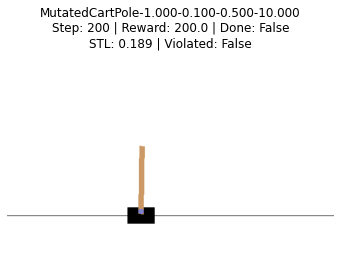

In [21]:
evaluate_dev(x_original, "gifs/default_env.gif")

### CMA for minimizing the STL robustness value given the bounded deviation

In [22]:
x = dev_violates_stl()

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=157253, Fri Jul 29 10:36:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.399442483951366e-01 1.0e+00 4.66e-01  5e-01  5e-01 0:07.4


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


    2     12 -2.500000099341070e-01 1.2e+00 4.54e-01  4e-01  6e-01 0:12.5
termination on ftarget=0.0 (Fri Jul 29 10:36:18 2022)
final/bestever f-value = 1.891264e-01 -2.500000e-01
incumbent solution: [0.7426852128661452, 0.4994428072485708]
std deviation: [0.5835507571380706, 0.4426149073630472]
CMAEvolutionStrategyResult(xbest=array([0.98444012, 0.07442413]), fbest=-0.250000009934107, evals_best=10, evaluations=13, iterations=2, xfavorite=array([0.74268521, 0.49944281]), stds=array([0.58355076, 0.44261491]), stop={'ftarget': 0.0})


Deviation: [1.97043624 2.41405843]
Deviation distance: 7.647761499548381
Initial parameter: [-0.04778415 -0.02075272 -0.0498502  -0.0475028 ]
Min robustness value: -0.250000009934107


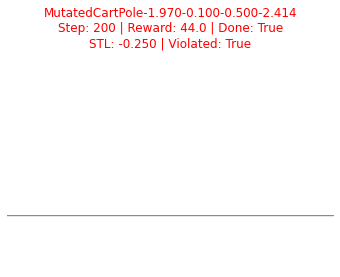

In [23]:
evaluate_dev(x, "gifs/counterexample.gif")

### CMA-ES for minimizing the deviation s.t. the STL is violated.

In [24]:
x = min_dev_violates_stl()


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=222819, Fri Jul 29 10:36:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.661688096283444e-02 1.0e+00 1.99e-01  2e-01  2e-01 0:06.9
    2     12 5.303739503184892e-01 1.2e+00 1.72e-01  1e-01  2e-01 0:14.5
    3     18 -1.331094632347275e+01 1.6e+00 2.25e-01  2e-01  3e-01 0:21.6
    4     24 -1.113664136626429e+05 2.5e+00 4.01e-01  4e-01  6e-01 0:27.5
    5     30 -1.091148279670743e+05 2.8e+00 4.96e-01  5e-01  7e-01 0:33.5
    6     36 -1.069024235629597e+05 2.4e+00 5.13e-01  5e-01  8e-01 0:40.6
    8     48 -1.030117018294463e+05 2.1e+00 3.50e-01  2e-01  4e-01 0:50.7
   10     60 -9.943007295710522e+04 2.4e+00 2.38e-01  1e-01  3e-01 0:58.6
   15     90 -8.813719054760068e+04 1.7e+00 2.05e-01  1e-01  2e-01 1:08.3
   20    120 -7.055876190138167e+04 3.4e+00 1.28e-01  4e-02  1e-01 1:20.1
   25    150 -4.344947089388862e+04 3.4e+00 1.12e-01  4e-0

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 1.3901795627938913, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    3     18 1.120803286536307e+10 1.9e+00 1.74e-01  1e-01  2e-01 0:20.8


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.4668839506970819, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    4     24 6.180941397367839e+09 2.2e+00 1.50e-01  7e-02  2e-01 0:28.0


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.3827497629455443, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    5     30 5.375424612418672e+09 2.7e+00 1.34e-01  6e-02  2e-01 0:35.3


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.46285001233326106, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    6     36 6.144434481974066e+09 3.2e+00 1.74e-01  6e-02  3e-01 0:42.6


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.17217789847699028, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    7     42 2.853747285013774e+09 5.0e+00 1.91e-01  6e-02  3e-01 0:50.0


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.23134636789694185, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    8     48 3.039235540229124e+09 5.3e+00 3.10e-01  1e-01  6e-01 0:57.3


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 0.4906128818143255, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


   10     60 1.913636442910192e+09 7.0e+00 3.71e-01  9e-02  7e-01 1:11.9
   12     72 1.890727970548285e+09 5.1e+00 4.86e-01  2e-01  6e-01 1:25.5
   14     84 -5.101271469969621e+08 2.6e+00 6.46e-01  3e-01  5e-01 1:39.1
   16     96 -4.447759217514262e+08 1.3e+00 6.50e-01  3e-01  3e-01 1:51.5
   19    114 -5.369114890249266e+09 1.2e+00 2.87e-01  8e-02  1e-01 2:04.6
   34    204 -5.934058597387189e+09 6.1e+00 4.11e-02  2e-03  1e-02 2:17.9
   56    336 -3.183036456079526e+07 5.4e+00 2.32e-01  1e-02  4e-02 2:32.3
   67    402 1.667201278576881e+00 3.7e+00 3.42e-01  1e-02  4e-02 2:49.2
   74    444 1.534028332824112e+00 1.8e+00 7.35e-01  3e-02  5e-02 3:08.3
   81    486 9.033323949695776e-01 1.6e+00 4.62e-01  1e-02  2e-02 3:29.8
   87    522 8.996164740029056e-01 1.3e+00 1.99e-01  3e-03  6e-03 3:49.7
   98    588 8.989086623171760e-01 2.3e+00 9.40e-02  7e-04  2e-03 4:10.2
  100    600 8.983010827998262e-01 3.9e+00 1.29e-01  8e-04  3e-03 4:16.0
  107    642 8.978676002415455e-01 2.7e+00 1.8

Deviation: [ 0.10379529 10.00453668]
Deviation distance: 0.8962161880023098
Initial parameter: [-0.03165839 -0.04793275 -0.03884435 -0.03354553]
Min robustness value: -0.0019189188907825505


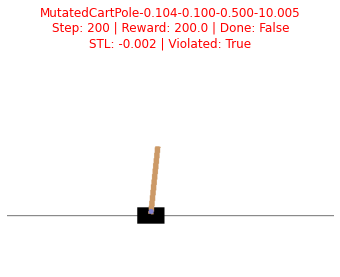

In [25]:
evaluate_dev(x, "gifs/min_dev_counterexample.gif")

### [Optional] CMA for finding the maximum deviation s.t. the agent is safe

In [26]:
x = max_safe_dev()


================ Trial 0 ==============>
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=214355, Fri Jul 29 11:07:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -3.196396966679526e+00 1.0e+00 1.86e-01  2e-01  2e-01 0:07.3
    2     12 -5.837474068766001e+00 1.1e+00 1.99e-01  2e-01  2e-01 0:14.5
    3     18 -7.471923399640191e+00 1.4e+00 3.27e-01  3e-01  4e-01 0:20.7


/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 3.9131970611205604, [0.], [4.07527551e-06]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    4     24 -1.493471312956700e+10 1.7e+00 5.69e-01  6e-01  8e-01 0:26.9
    6     36 -1.473153845813807e+10 2.4e+00 6.92e-01  6e-01  8e-01 0:37.1
    7     42 -1.463256137498657e+10 2.3e+00 5.27e-01  4e-01  5e-01 0:44.3
    8     48 -1.454098873440979e+10 1.9e+00 4.27e-01  3e-01  4e-01 0:50.5
    9     54 -1.445839775383661e+10 1.7e+00 3.52e-01  2e-01  2e-01 0:57.8
   11     66 -1.429812691621337e+10 1.7e+00 2.07e-01  1e-01  1e-01 1:12.3
   13     78 -1.411815670874580e+10 1.7e+00 1.39e-01  5e-02  7e-02 1:26.9
   15     90 -1.391329846813864e+10 1.7e+00 1.05e-01  3e-02  5e-02 1:41.4
   17    102 -1.366161208081479e+10 1.8e+00 9.97e-02  2e-02  4e-02 1:55.9
   19    114 -1.336230483825229e+10 2.4e+00 7.92e-02  1e-02  3e-02 2:10.4
   21    126 -1.300636653582565e+10 2.8e+00 6.11e-02  8e-03  2e-02 2:24.9
   23    138 -1.258308217407676e+10 3.1e+00 4.43e-02  5e-03  1e-02 2:39.5
   26    156 -1.179336054943315e+10 3.0e+00 3.02e-02  2e-03  6e-03 3:01.2
   29    174 -1.076921830943182e+10 2.

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/cma/constraints_handler.py:987: UserWarning: iqr(f), iqr(G), iqr(G**2)) == 3.4325663049534856, [0.], [0.]
  _warnings.warn("iqr(f), iqr(G), iqr(G**2)) == %s, %s, %s" % (str(df), str(dG), str(dG2)))


    3     18 -1.451051486264525e+10 1.9e+00 3.43e-01  2e-01  5e-01 0:20.9
    4     24 -1.440262294931484e+10 2.3e+00 2.91e-01  2e-01  4e-01 0:26.4
    5     30 -1.429658455320793e+10 2.6e+00 2.61e-01  1e-01  4e-01 0:32.7
    6     36 -1.419236783673790e+10 2.6e+00 2.06e-01  1e-01  3e-01 0:37.8
    8     48 -1.400898098119645e+10 4.5e+00 2.50e-01  1e-01  4e-01 0:49.6
    9     54 -1.393390544502415e+10 4.0e+00 2.89e-01  1e-01  5e-01 0:57.0
   10     60 -1.384021693506682e+10 4.9e+00 4.34e-01  2e-01  8e-01 1:05.2
   12     72 -1.365087548743787e+10 5.6e+00 7.68e-01  2e-01  1e+00 1:18.0
   14     84 -1.343674303162651e+10 7.6e+00 8.39e-01  2e-01  2e+00 1:31.4
   16     96 -1.317088034680434e+10 8.6e+00 5.62e-01  1e-01  9e-01 1:44.5
   18    108 -1.285740311235268e+10 1.2e+01 6.10e-01  1e-01  1e+00 1:59.3
   20    120 -1.248092781900450e+10 1.5e+01 8.12e-01  1e-01  1e+00 2:13.8
   22    132 -1.204023108342083e+10 1.1e+01 8.01e-01  1e-01  1e+00 2:30.2
   25    150 -1.120259542208597e+10 1.

Deviation: [ 1.99999918 20.        ]
Deviation distance: 10.049875537867333
Initial parameter: [-0.03522084 -0.04885058 -0.04999759 -0.04998998]
Min robustness value: 0.18912636538045768


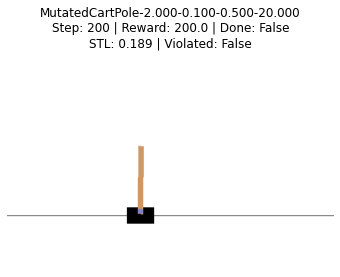

In [28]:
evaluate_dev(x, "gifs/max_safe_deviation.gif")

### Plot the shape of the optimization space using grid

In [29]:
n_mass, n_force = (25, 25)
masses = np.linspace(masscart[0], masscart[1], n_mass)
forces = np.linspace(force_mag[0], force_mag[1], n_force)
masses, forces = np.meshgrid(masses, forces, indexing='ij')

In [30]:
stl_falsify_target = -np.inf
grid_data = np.zeros((n_mass, n_force))

for i in range(n_mass):
    for j in range(n_force):
        # treat xv[i,j], yv[i,j]
        m, f = masses[i, j], forces[i, j]
        robustness, _ = falsification_by_CMA([m, f])
        grid_data[i, j] = robustness

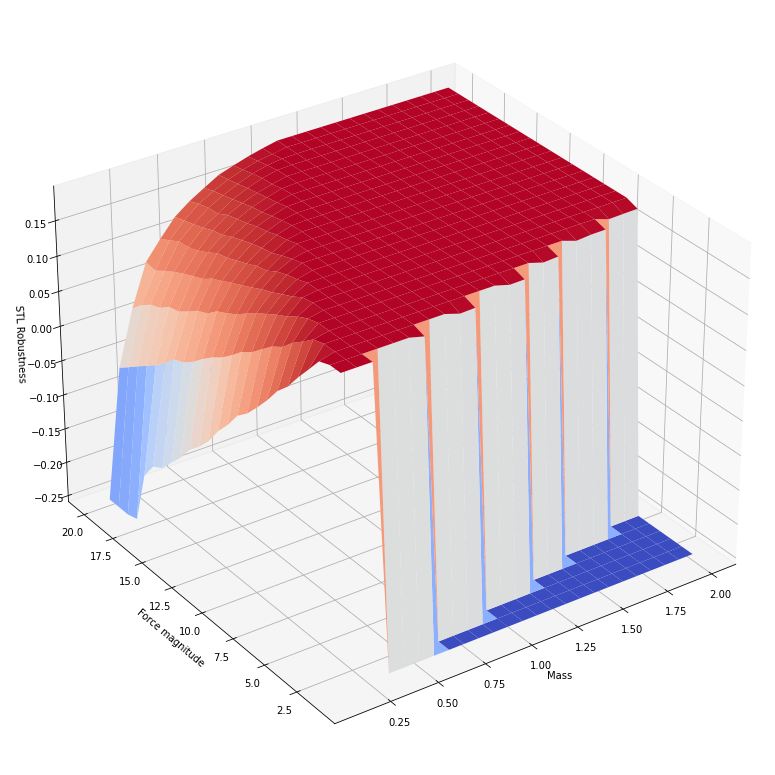

In [30]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))
ax.plot_surface(masses, forces, grid_data, cmap=cm.coolwarm)
ax.set_xlabel('Mass')
ax.set_ylabel('Force magnitude')
ax.set_zlabel('STL Robustness')
# ax.set_zlim(-0.26, 0.2)

ax.view_init(30, -125)
plt.savefig('gifs/robustness-landscape.png')
plt.show()

In [32]:
if not os.path.exists('data'):
    os.mkdir('data')

np.savetxt("data/masses.csv", masses, delimiter=",")
np.savetxt("data/forces.csv", forces, delimiter=",")
np.savetxt("data/grid_data.csv", grid_data, delimiter=",")

### Using accelaration to understand the plot

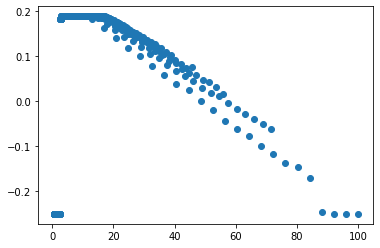

In [33]:
acc = forces / (masses + 0.1)
plt.scatter(acc.flatten(), grid_data.flatten())